In [1]:
import os.path as osp
import sys
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path(osp.abspath("")).parents[1]
sys.path.append(str(root_path))

%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
from algorithm import SmoothedPath
from core.curve import Line, Bezier
from core.toolpath import LinearPath
import utils.visualization as vis
from core.feedrate_planner import BidirectionalScanner

In [3]:
data_name = "butterfly"
file_path = f"./data/{data_name}.txt"
data_pts = np.loadtxt(file_path, delimiter="\t")
Ts = 0.0005

v_max = 100
a_max = 3000
j_max = 60000
chord_error = 0.05
c1 = 0.5


data_pts = data_pts / 10
print(f"Loaded data from {file_path}")
print(f"Data points shape: {data_pts.shape}")

Loaded data from ./data/butterfly.txt
Data points shape: (100, 2)


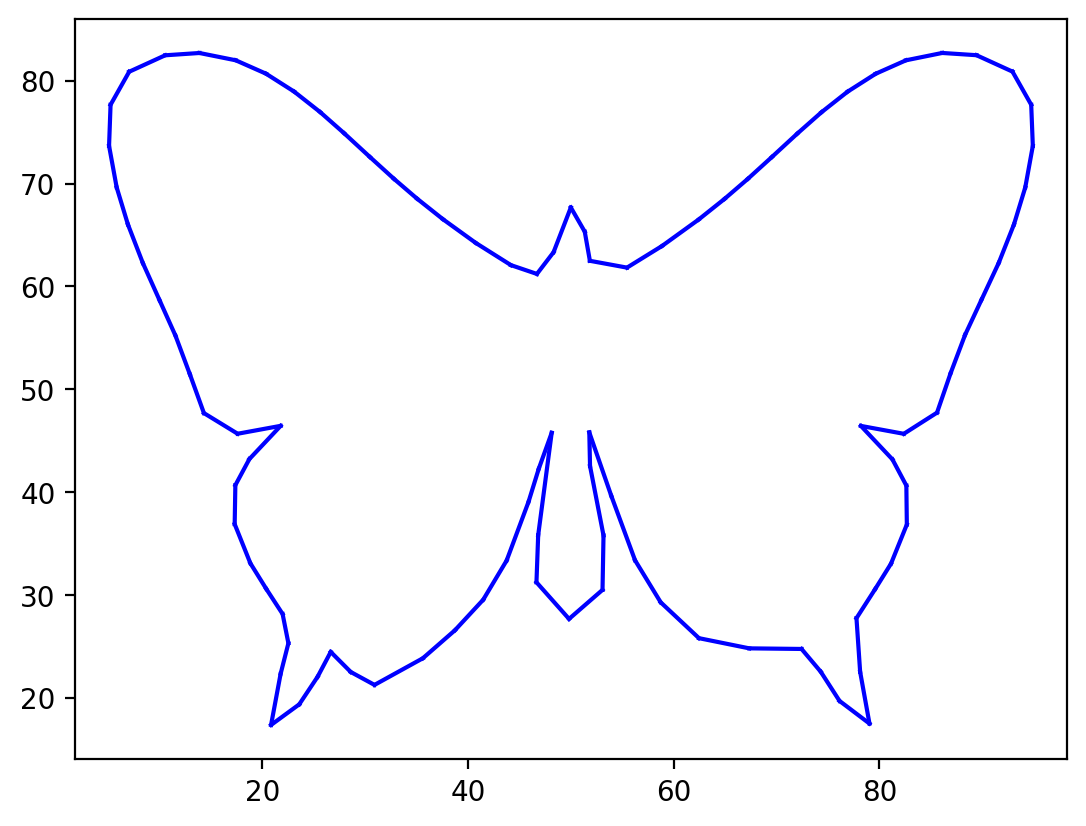

In [4]:
linear_path = LinearPath(data_pts, chord_error)
vis.plot_toolpath(linear_path)

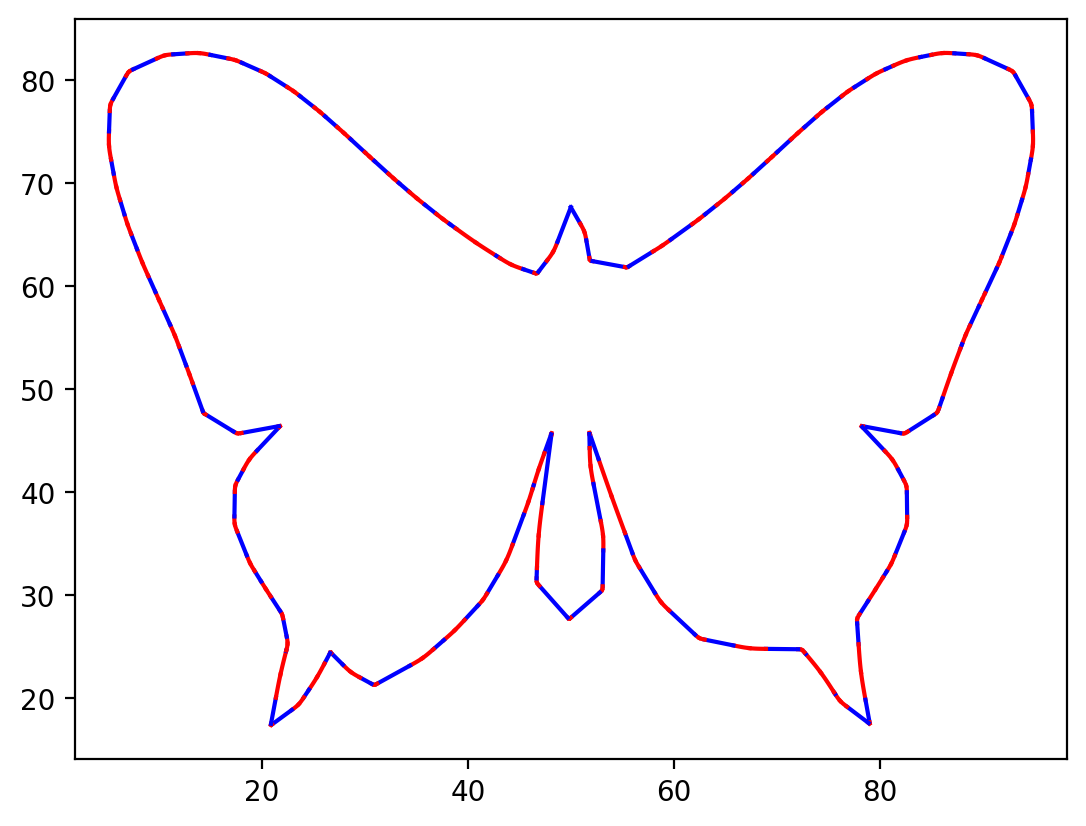

In [5]:
smooth_path = SmoothedPath(data_pts, chord_error, c1)
vis.plot_toolpath(smooth_path)

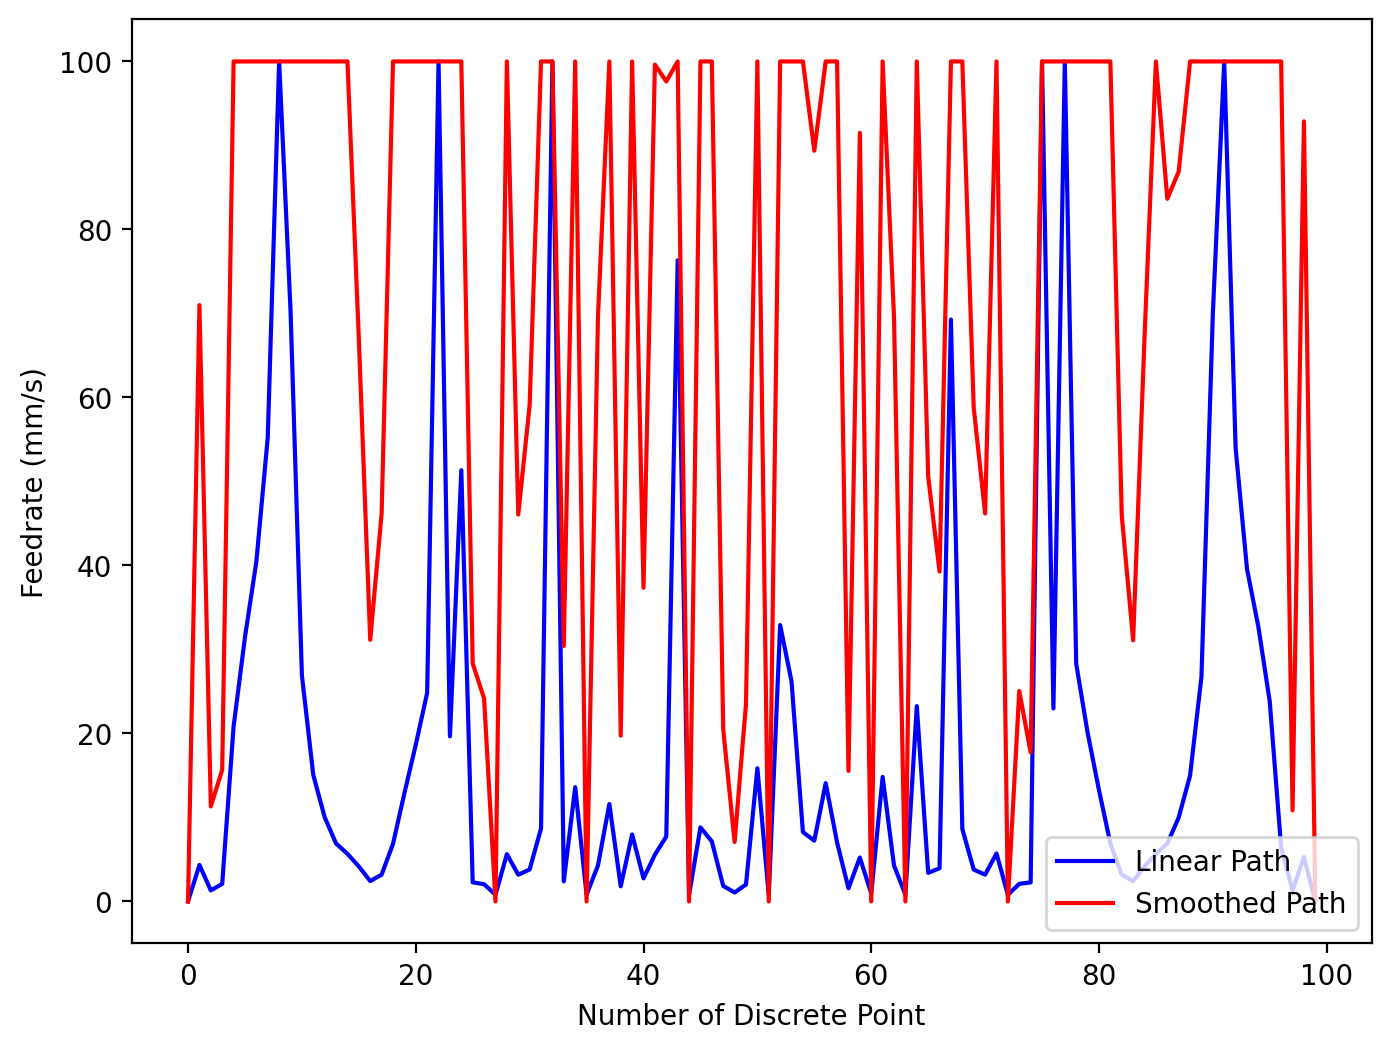

In [6]:
linear_scanner = BidirectionalScanner(linear_path, Ts, v_max, a_max, j_max)

scanner_smooth = BidirectionalScanner(smooth_path, Ts, v_max, a_max, j_max)

v_lim_linear = linear_scanner.v_limit
v_lim_smooth = scanner_smooth.v_limit


plt.figure(figsize=(8, 6))
plt.plot(v_lim_linear, "b-", label="Linear Path")
plt.plot(v_lim_smooth, "r-", label="Smoothed Path")
plt.xlabel("Number of Discrete Point")
plt.ylabel("Feedrate (mm/s)")
plt.legend(loc="lower right")
plt.show()